In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

https://www.ime.unicamp.br/~mac/db/2020-1S-167296.pdf
pagina 10, Figura 3
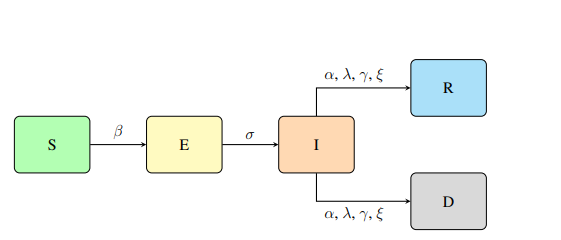

https://www.ime.unicamp.br/~mac/db/2020-1S-167296.pdf 
página 10, Figura 3

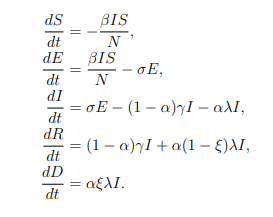

Favor checar se a segunda equação não seria: 

dEdt = IS/N - βσE,

pois o número de Expostos deveria diminuir se eles tendem a ficar mais doentes. 

para o sigma:

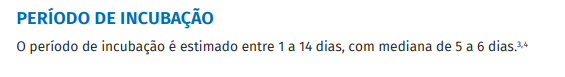

https://www.ibge.gov.br/cidades-e-estados/pe.html


9.674.793 pessoas
 

In [23]:
class SEIRD:
    # colocar valores padroes de acordo com base de dados. Organizar a ordem dos parametros
    
    def __init__(self,
                 periodo_incubacao    = 3,
                 taxa_infeccao        = 0.5,
                 taxa_internacao      = 0.5,
                 Tempo_internado      = 10,
                 Tempo_doente         = 20,
                 mortalidade_hospital = 0.1,
                 y0 = (9674793 - 1, 0,1,0,0)):     # y0 = (S0,E0,I0,R0,D0)

        self.β  =  taxa_infeccao            # o quanto tende uma pessoa exposta a ficar doente
        self.σ  = 1/periodo_incubacao       #  taxa de incubacao
        self.γ  = 1/Tempo_doente            #  
        self.λ  =  1/Tempo_internado        # 1/(tempo que passa no hospital)
        self.α  = taxa_internacao           # o quanto um infectado tende a internar-se
        self.ξ  = mortalidade_hospital      # taxa mortalidade do hospital 
        self.y0 = y0
        self.y = None


    def solve(self):

        def equacao(y, t, N, beta, sigma, alpha, gamma, Lambda, csi):
            S,E,I,R,D     =  y
            β, σ, α, γ, λ, ξ =  beta, sigma, alpha, gamma, Lambda, csi
            
            dSdt = -β*I*S/N                 # Suscetiveis diminui com o numero de infectados
            dEdt = β*I*S/N - σ*E            # Expostos aumentam se temos muitos infectados e diminui quando ficam infectados
            dIdt = σ*E - (1-α)*γ*I - α*λ*I  # Infectados aumentam com mais exposicao e diminuem com recuperacao
            dRdt = (1-α)*γ*I + α*(1-ξ)*λ*I  # Recuperados aumentam com recuperacoes em casa e alta do hospital
            dDdt = α*ξ*λ*I                  # Mortos aumentam com infectados que foram internados morreram no hospital

            return np.array( [dSdt, dEdt, dIdt, dRdt, dDdt] )

        #guardamos a solucao
        self.y = odeint( equacao,
                            self.y0,
                            np.linspace(start = 0, stop = 365, num = 100),
                            args = (
                                    9674793,
                                    self.β,
                                    self.σ,
                                    self.α,
                                    self.γ,
                                    self.λ,
                                    self.ξ
                                    )
                    ).T #transposing

    def plot(self):
        #se ainda nao solucionamos,
        #usamos a funcao solve
        if self.y is None: self.solve()

        color = ['g','y','r','c','black']
        #plot em S,E,I,R,D
        for i,Var in enumerate(self.y):
            plt.plot(np.linspace(start = 0, stop = 365, num = 100),Var, color[i])
        
        plt.legend("SEIRD")
        plt.xlabel("dia") 
        plt.ylabel("populacao")      

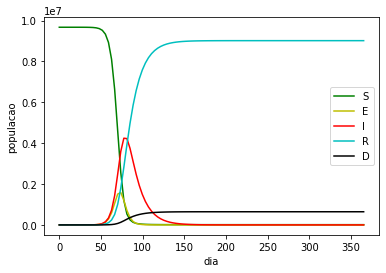

In [24]:
modelo = SEIRD()
modelo.plot()